<a href="https://colab.research.google.com/github/vhoma/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [1]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



  Cloning https://github.com/pydicom/pydicom.git to /tmp/pip-req-build-car0rtju
  Running command git clone -q https://github.com/pydicom/pydicom.git /tmp/pip-req-build-car0rtju


In [2]:
import dicom_utils as dcm
import Affine3D as affine
import data_loader as dl
from scipy.ndimage import affine_transform

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [3]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

#home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")

#data_path = os.path.join(home_path, "data")
#print(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# (OPTIONAL) can run this to copy from drive and unzip

from zipfile import ZipFile, BadZipFile

# copy from drive to local storage
!cp /content/drive/MyDrive/YDATA/viz-ai/data100.zip ./

# unzip
archive_path = "./data100.zip"
with ZipFile(archive_path, 'r') as zip_obj:
    zip_obj.extractall("./data/")

# set main data dir
home_path = "./data"

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import copy

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [12]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

### Variant 1 (concatenating the input)

In [ ]:
class Our_AirNet(nn.Module):
    def __init__(self):
        super(Our_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))    
        
    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition(inp) #80
        inp = self.transition(inp) #40
        inp = self.transition(inp) #20
        input_conc = torch.cat((inp[:inp.shape[0]].flatten(),inp[inp.shape[0]:].flatten()),dim=0)
        #inp = self.flatten(inp)
        res = self.regression(input_conc)
        return res        



In [ ]:
model = Our_AirNet()
summary(model, (20, 320, 320), batch_size=1)

TypeError: ignored

In [ ]:

a = torch.rand(1,3,5,5) # input a
print(a.shape)
b = torch.rand(1,3,5,5) # input b
print(b.shape)
c = torch.cat((a,b),dim=0) # stack them batch-wise
n=a.shape[0]
c.shape

d = torch.cat((c[:a.shape[0]].flatten(),c[a.shape[0]:].flatten()),dim=0)
d.shape
#print(input_conc)
c[:a.shape[0]].shape

a = a.flatten()
a.shape
b = b.flatten()
c.shape
c = torch.cat((a,b), dim=0)


torch.Size([150])

In [6]:
# using custom DataSet class from data_loader.py
dataset = dl.Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
%%time
x, y, matrix = next(iter(dataloader))

...transformed with angles: 42 -10
CPU times: user 1.57 s, sys: 31.3 ms, total: 1.6 s
Wall time: 1.59 s


In [8]:
x.shape, y.shape, matrix.shape

(torch.Size([1, 20, 320, 320]),
 torch.Size([1, 20, 320, 320]),
 torch.Size([1, 3, 4]))

In [9]:
matrix1 = matrix[:,:3,:]

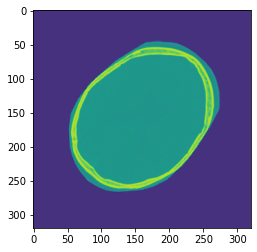

In [10]:
plt.imshow(x[0][10,:,:])

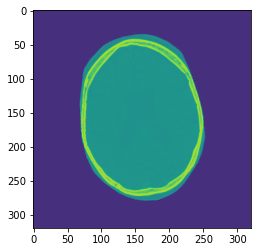

In [11]:
plt.imshow(y[0][10,:,:])

#Running model

In [130]:
model = Our_AirNet()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 200

NameError: ignored

In [106]:
best_loss = np.inf
loss_history = [] 
best_model_wts = copy.deepcopy(model.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model(x, y)
        #print(res.shape)
        print(res)
        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts = copy.deepcopy(model.state_dict())

        loss_history.append(loss.item())



print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model.load_state_dict(best_model_wts)
#y.shape

NameError: ignored

In [ ]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])


print('the output of the model')
model.load_state_dict(best_model_wts)
result_matrix = model(x, y)


tensor([[ 9.8147e-01, -8.1401e-03,  5.1716e-03,  1.1570e+01,  7.4433e-02,
          1.0004e+00, -2.1785e-02, -1.0747e+01, -5.9782e-03, -1.8252e-02,
          1.0093e+00,  2.6488e-02],
        [ 9.7994e-01, -8.4565e-03,  4.6730e-03,  1.1575e+01,  7.3543e-02,
          1.0003e+00, -2.2586e-02, -1.0752e+01, -6.4863e-03, -1.8585e-02,
          1.0096e+00,  2.7398e-02]], grad_fn=<AddmmBackward0>)

###Variant2 (Siamese network)

In [12]:
class Siam_AirNet(nn.Module):
    def __init__(self):
        super(Siam_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))   

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.firstlayer(x)
        output = self.transition(output)
        output = self.transition(output)
        output = self.transition(output)
        output = self.flatten(output)        
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        input_t = self.forward_once(input_t)
        #print(input_t.shape)
        input_ref = self.forward_once(input_ref)
        #print(input_ref.shape)
        input_conc = torch.cat((input_t,input_ref),dim=1)
        #print(input_conc.shape)
        res = self.regression(input_conc)
        return res 

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
model2 = Siam_AirNet()
model2.train()
model2 = model2.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 300

tensor([[-0.0854,  0.0806,  0.0036, -0.1233, -0.0869,  0.0968,  0.0745,  0.1002,
          0.0072, -0.0515, -0.1048,  0.0952]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 0
 Current loss 39305.7734375

tensor([[-1.3234e+01, -1.5431e+01, -1.5258e+01, -2.0429e+01, -2.9155e-02,
          2.7426e+01,  1.9145e+01,  5.2826e+01,  1.0220e+01, -1.1332e+01,
          1.6321e-01,  1.0888e+01]], device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch number 1
 Current loss 22233.224609375

tensor([[ -26.7304,  -21.4932,  -50.9862, -162.3786,  -36.6035,   76.9510,
           27.2934,  302.2787,   12.3538,  -34.3009,   12.7822,  -13.4442]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Epoch number 2
 Current loss 36067.18359375

tensor([[  0.8662,   2.8039,  -8.2375, -30.4142,  -0.1464,   8.0927,  -2.6403,
          76.1560,  -7.9934,  -4.6630,  -4.6690,  -5.8067]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 3
 Current loss 13868.9658203125

tensor([[  5.9437,  

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 4
 Current loss 20734.1015625

tensor([[ 12.0826,  20.5647,  -8.7750, -11.6151,  19.9304, -12.3467,  -8.3617,
          68.4253, -13.5657,  -1.9324,  -2.4443, -11.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 5
 Current loss 18612.15625

tensor([[ 22.2432,  42.7579, -12.5409, -16.1883,  39.9430, -27.4342, -14.2981,
         118.1013, -19.2095,  -1.6749,   1.0657, -19.2633]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 6
 Current loss 12948.8388671875

tensor([[ 33.3244,  52.7976,  -6.0155, -35.2088,  54.2038, -39.8554, -18.2528,
         193.2807, -19.0380,  -2.0378,   1.2987, -17.4678]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 7
 Current loss 10373.689453125

tensor([[ 32.0460,  20.5947,  19.7802, -53.2701,  32.4878, -19.7615, -10.3367,
         192.7714,   0.2488,  -9.4956,  -4.8639,   6.7331]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch number 8
 Current loss 3725.814453125

tensor([[ 19.762

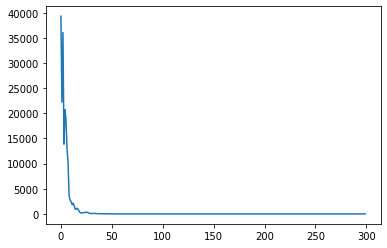

<All keys matched successfully>

In [15]:
best_loss = np.inf
loss_history = [] 
best_model_wts2 = copy.deepcopy(model2.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        matrix_gpu = matrix.to(device)

        # Pass in the two images into the network and obtain two outputs
        res = model2(x_gpu, y_gpu)
        print(res)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix_gpu.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts2 = copy.deepcopy(model2.state_dict())

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model2.load_state_dict(best_model_wts2)


### Model output check

the input


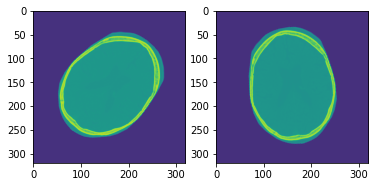

In [16]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])




the output of the model
tensor(310056.0938)
310055.5
310040.75


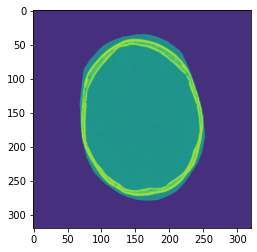

tensor(129.6454, dtype=torch.float64)
129.64541046693137


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
print('the output of the model')

result_matrix = model2(x_gpu, y_gpu)
result_matrix = result_matrix.cpu().detach().numpy()
print(y.sum())
result_matrix_new = np.append(result_matrix,[0, 0, 0, 1]).reshape(4,4)
result_matrix.shape
x_nmp = x.detach().numpy()[0].transpose(1, 2, 0)
print(x_nmp.sum())
plt.imshow(x_nmp[:,:,10])
x_new = affine_transform(x_nmp, result_matrix_new)
print(x_new.sum())
plt.imshow(x_new[:,:,10])
plt.show()

m_check = np.array([[0.7431448, 0.6691306, 0., -65.964066 ],
 [-0.6691306, 0.7431448, 0., 148.15773],
 [0.,0., 1., 0.]])
m_check = m_check.flatten()


err = np.sum(np.power(np.subtract(m_check, result_matrix),2))/12

#y_nmp.shape

mse = nn.MSELoss()
m_check_tensor = torch.tensor(m_check)
matrix_tensor = torch.tensor(result_matrix)
print(mse(m_check_tensor, matrix_tensor))
print(err)

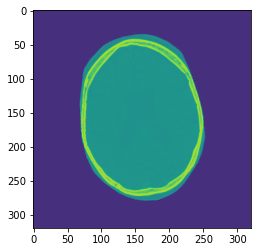

In [18]:
#plt.imshow(y[:,:,10])
y_nmp = y.detach().numpy()[0].transpose(1, 2, 0)
plt.imshow(y_nmp[:,:,10])

In [19]:
matrix

tensor([[[  0.6157,   0.7880,   0.0000, -64.5876],
         [ -0.7880,   0.6157,   0.0000, 187.5759],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

In [20]:
res.cpu().detach().numpy()

array([[ 6.1565906e-01,  7.8801745e-01, -3.2708049e-06, -6.4587601e+01,
        -7.8800744e-01,  6.1567050e-01,  8.5085630e-06,  1.8757587e+02,
        -3.1851232e-07,  1.1966564e-05,  1.0000060e+00, -1.5147030e-05]],
      dtype=float32)

In [140]:
x_65 = torch.tensor(np.array([  1.0197,   0.2484,  -0.4615, -65.7467,  -0.9316,   0.5529,  -0.8590,
         147.3966,  -0.2259,   0.2153,   1.0492,  -0.2639]))
x_65.shape

torch.Size([12])

In [141]:
mse(m_check_tensor, res.cpu().detach())
mse(m_check_tensor, x_65)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1755, dtype=torch.float64)